Varshini Balaji
DDQN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


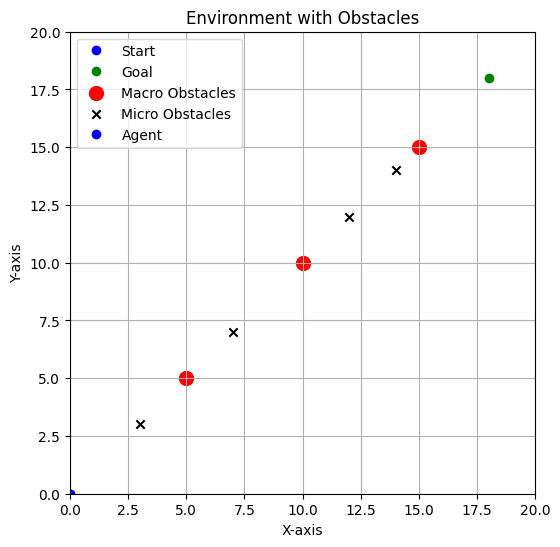

In [ ]:
# Environment setup
env_size = (20, 20)
start_position = np.array([0, 0])
goal_position = np.array([18, 18])
macro_obstacles = [np.array([5, 5]), np.array([10, 10]), np.array([15, 15])]
micro_obstacles = [np.array([3, 3]), np.array([7, 7]), np.array([12, 12]), np.array([14, 14])]

# Display environment
def display_environment(agent_pos):
    plt.figure(figsize=(6, 6))
    plt.xlim(0, env_size[0])
    plt.ylim(0, env_size[1])
    plt.plot(start_position[0], start_position[1], 'bo', label="Start")
    plt.plot(goal_position[0], goal_position[1], 'go', label="Goal")
    macro_x, macro_y = zip(*macro_obstacles)
    micro_x, micro_y = zip(*micro_obstacles)
    plt.scatter(macro_x, macro_y, color='red', s=100, label="Macro Obstacles")
    plt.scatter(micro_x, micro_y, color='black', marker='x', label="Micro Obstacles")
    plt.plot(agent_pos[0], agent_pos[1], 'bo', label="Agent")
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.grid(True)
    plt.title("Environment with Obstacles")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.show()

# Display the environment with the agent at the start position
display_environment(start_position)

In [ ]:
# Neural network for Q-value approximation
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)  # Q-values for each action


In [ ]:
# Reward function
def calculate_reward(agent_pos):
    if np.array_equal(agent_pos, goal_position):
        return 100  # Reward for reaching the goal

    distance_to_goal = np.linalg.norm(agent_pos - goal_position)
    start_to_goal = np.linalg.norm(start_position - goal_position)
    reward = max(0, 1 - distance_to_goal / start_to_goal)

    for obs in macro_obstacles:
        reward -= max(0, 10 * (2 - np.linalg.norm(agent_pos - obs)))
    for obs in micro_obstacles:
        reward -= max(0, 5 * (1 - np.linalg.norm(agent_pos - obs)))

    reward -= 0.5  # Step penalty
    return reward

# Agent position update based on action
def update_position(agent_pos, action):
    if action == 0:  # Right
        agent_pos[0] = min(agent_pos[0] + 1, env_size[0] - 1)
    elif action == 1:  # Left
        agent_pos[0] = max(agent_pos[0] - 1, 0)
    elif action == 2:  # Up
        agent_pos[1] = min(agent_pos[1] + 1, env_size[1] - 1)
    elif action == 3:  # Down
        agent_pos[1] = max(agent_pos[1] - 1, 0)
    return agent_pos

In [ ]:
# Hyperparameters
state_dim = 2  # State: agent's position (x, y)
action_dim = 4  # Actions: [right, left, up, down]
gamma = 0.99
epsilon = 1.0  # Epsilon-greedy exploration
epsilon_min = 0.01
epsilon_decay = 0.995
batch_size = 64
learning_rate = 1e-3
buffer_size = 10000
num_episodes = 2000
target_update_freq = 10

# Replay buffer
replay_buffer = deque(maxlen=buffer_size)

# Initialize networks and optimizer
q_network = DQN(state_dim, action_dim)
target_network = DQN(state_dim, action_dim)
target_network.load_state_dict(q_network.state_dict())
optimizer = optim.Adam(q_network.parameters(), lr=learning_rate)

Episode 0: Reward = -88.09, Epsilon = 0.99
Episode 100: Reward = -58.40, Epsilon = 0.60
Episode 200: Reward = 62.70, Epsilon = 0.37
Episode 300: Reward = 101.00, Epsilon = 0.22
Episode 400: Reward = 49.00, Epsilon = 0.13
Episode 500: Reward = 101.55, Epsilon = 0.08
Episode 600: Reward = 101.64, Epsilon = 0.05
Episode 700: Reward = -43.05, Epsilon = 0.03
Episode 800: Reward = -30.82, Epsilon = 0.02
Episode 900: Reward = 8.25, Epsilon = 0.01
Episode 1000: Reward = 51.73, Epsilon = 0.01
Episode 1100: Reward = 64.20, Epsilon = 0.01
Episode 1200: Reward = 69.63, Epsilon = 0.01
Episode 1300: Reward = 74.01, Epsilon = 0.01
Episode 1400: Reward = 101.74, Epsilon = 0.01
Episode 1500: Reward = 100.41, Epsilon = 0.01
Episode 1600: Reward = 77.78, Epsilon = 0.01
Episode 1700: Reward = 100.52, Epsilon = 0.01
Episode 1800: Reward = 101.78, Epsilon = 0.01
Episode 1900: Reward = 100.69, Epsilon = 0.01


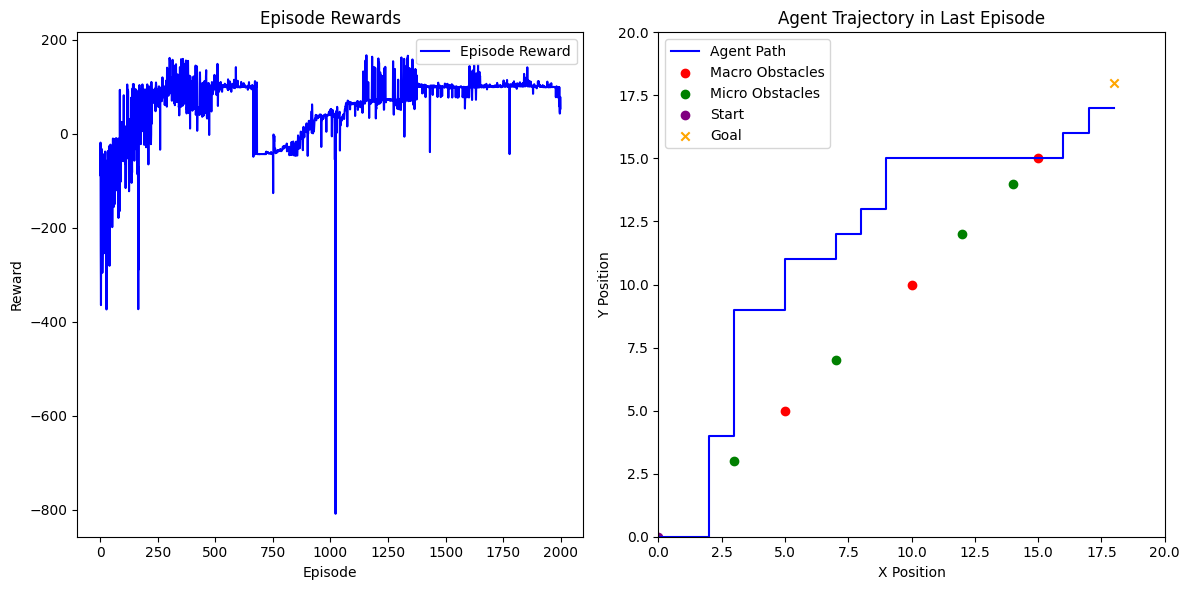

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim

# Assuming q_network, target_network, epsilon, gamma, replay_buffer, etc., are already defined.

# Training loop
episode_rewards = []
trajectory_data = []  # To store the trajectory for plotting

for episode in range(num_episodes):
    agent_pos = start_position.copy()
    episode_reward = 0
    steps = 0
    trajectory = []  # List to store positions in the current episode

    while not np.array_equal(agent_pos, goal_position) and steps < 200:
        state = torch.FloatTensor(agent_pos)

        # Epsilon-greedy action selection
        if random.random() < epsilon:
            action = random.choice(range(action_dim))
        else:
            with torch.no_grad():
                action = q_network(state).argmax().item()

        # Take action and observe next state and reward
        next_pos = update_position(agent_pos.copy(), action)
        reward = calculate_reward(next_pos)
        done = np.array_equal(next_pos, goal_position)
        episode_reward += reward

        # Store transition in replay buffer
        replay_buffer.append((state, action, reward, next_pos, done))

        # Append current position to the trajectory
        trajectory.append(agent_pos.copy())

        agent_pos = next_pos
        steps += 1

        # Training step
        if len(replay_buffer) >= batch_size:
            batch = random.sample(replay_buffer, batch_size)
            states, actions, rewards, next_states, dones = zip(*batch)

            states = torch.stack(states)
            actions = torch.LongTensor(actions)
            rewards = torch.FloatTensor(rewards)
            next_states = torch.FloatTensor(next_states)
            dones = torch.FloatTensor(dones)

            # Q-value updates
            q_values = q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)
            with torch.no_grad():
                next_actions = q_network(next_states).argmax(dim=1)
                next_q_values = target_network(next_states).gather(1, next_actions.unsqueeze(1)).squeeze(1)
                target_q_values = rewards + (1 - dones) * gamma * next_q_values

            loss = nn.MSELoss()(q_values, target_q_values)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Update target network
    if episode % target_update_freq == 0:
        target_network.load_state_dict(q_network.state_dict())

    # Decay epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    # Track episode reward
    episode_rewards.append(episode_reward)

    # Store trajectory for plotting
    trajectory_data.append(np.array(trajectory))

    # Print progress every 100 episodes
    if episode % 100 == 0:
        print(f"Episode {episode}: Reward = {episode_reward:.2f}, Epsilon = {epsilon:.2f}")

# Plotting episode rewards
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(num_episodes), episode_rewards, label='Episode Reward', color='blue')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Episode Rewards')
plt.legend()

# Plotting agent trajectory of the last episode
plt.subplot(1, 2, 2)
last_trajectory = trajectory_data[-1]
plt.plot(last_trajectory[:, 0], last_trajectory[:, 1], label='Agent Path', color='blue')
plt.scatter([macro[0] for macro in macro_obstacles], [macro[1] for macro in macro_obstacles], color='red', label='Macro Obstacles')
plt.scatter([micro[0] for micro in micro_obstacles], [micro[1] for micro in micro_obstacles], color='green', label='Micro Obstacles')
plt.scatter(start_position[0], start_position[1], color='purple', label='Start', marker='o')
plt.scatter(goal_position[0], goal_position[1], color='orange', label='Goal', marker='x')
plt.xlim(0, env_size[0])
plt.ylim(0, env_size[1])
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Agent Trajectory in Last Episode')
plt.legend()

plt.tight_layout()
plt.show()


Episode 0: Reward = -32.59, Epsilon = 1.00
Episode 100: Reward = -57.20, Epsilon = 0.95
Episode 200: Reward = -246.46, Epsilon = 0.90
Episode 300: Reward = -88.05, Epsilon = 0.86
Episode 400: Reward = -246.89, Epsilon = 0.82
Episode 500: Reward = 62.55, Epsilon = 0.78
Episode 600: Reward = 111.21, Epsilon = 0.74
Episode 700: Reward = 79.23, Epsilon = 0.70
Episode 800: Reward = 7.73, Epsilon = 0.67
Episode 900: Reward = 87.58, Epsilon = 0.64
Episode 1000: Reward = 60.36, Epsilon = 0.61
Episode 1100: Reward = 101.20, Epsilon = 0.58
Episode 1200: Reward = 116.72, Epsilon = 0.55
Episode 1300: Reward = 95.61, Epsilon = 0.52
Episode 1400: Reward = 111.21, Epsilon = 0.50
Episode 1500: Reward = 76.16, Epsilon = 0.47
Episode 1600: Reward = 119.12, Epsilon = 0.45
Episode 1700: Reward = 99.29, Epsilon = 0.43
Episode 1800: Reward = 96.53, Epsilon = 0.41
Episode 1900: Reward = 96.45, Epsilon = 0.39
Episode 2000: Reward = 105.68, Epsilon = 0.37
Episode 2100: Reward = 103.05, Epsilon = 0.35
Episode 2

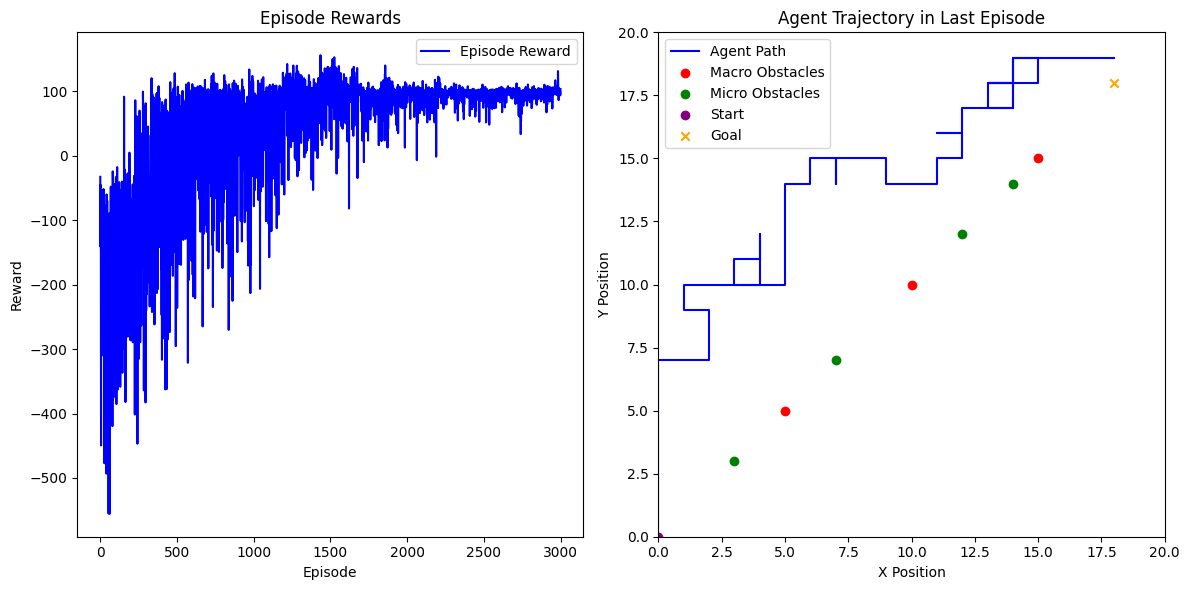

In [ ]:
# Hyperparameters
state_dim = 2  # State: agent's position (x, y)
action_dim = 4  # Actions: [right, left, up, down]
gamma = 0.99
epsilon = 1.0  # Epsilon-greedy exploration
epsilon_min = 0.01
epsilon_decay = 0.9995  # Slower decay to allow more exploration
batch_size = 64
learning_rate = 1e-3
buffer_size = 10000
num_episodes = 3000  # Increased number of episodes
target_update_freq = 10

# Replay buffer
replay_buffer = deque(maxlen=buffer_size)

# Initialize networks and optimizer
q_network = DQN(state_dim, action_dim)
target_network = DQN(state_dim, action_dim)
target_network.load_state_dict(q_network.state_dict())
optimizer = optim.Adam(q_network.parameters(), lr=learning_rate)

# Training loop with more exploration and episodes
episode_rewards = []
trajectory_data = []  # To store the trajectory for plotting

for episode in range(num_episodes):
    agent_pos = start_position.copy()
    episode_reward = 0
    steps = 0
    trajectory = []  # List to store positions in the current episode

    while not np.array_equal(agent_pos, goal_position) and steps < 200:
        state = torch.FloatTensor(agent_pos)

        # Epsilon-greedy action selection
        if random.random() < epsilon:
            action = random.choice(range(action_dim))  # Random action (exploration)
        else:
            with torch.no_grad():
                action = q_network(state).argmax().item()  # Best action (exploitation)

        # Take action and observe next state and reward
        next_pos = update_position(agent_pos.copy(), action)
        reward = calculate_reward(next_pos)
        done = np.array_equal(next_pos, goal_position)
        episode_reward += reward

        # Store transition in replay buffer
        replay_buffer.append((state, action, reward, next_pos, done))

        # Append current position to the trajectory
        trajectory.append(agent_pos.copy())

        agent_pos = next_pos
        steps += 1

        # Training step (Q-learning update)
        if len(replay_buffer) >= batch_size:
            batch = random.sample(replay_buffer, batch_size)
            states, actions, rewards, next_states, dones = zip(*batch)

            states = torch.stack(states)
            actions = torch.LongTensor(actions)
            rewards = torch.FloatTensor(rewards)
            next_states = torch.FloatTensor(next_states)
            dones = torch.FloatTensor(dones)

            # Q-value updates
            q_values = q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)
            with torch.no_grad():
                next_actions = q_network(next_states).argmax(dim=1)
                next_q_values = target_network(next_states).gather(1, next_actions.unsqueeze(1)).squeeze(1)
                target_q_values = rewards + (1 - dones) * gamma * next_q_values

            loss = nn.MSELoss()(q_values, target_q_values)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Update target network periodically
    if episode % target_update_freq == 0:
        target_network.load_state_dict(q_network.state_dict())

    # Decay epsilon (slower decay for more exploration)
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    # Track episode reward
    episode_rewards.append(episode_reward)

    # Store trajectory for plotting
    trajectory_data.append(np.array(trajectory))

    # Print progress every 100 episodes
    if episode % 100 == 0:
        print(f"Episode {episode}: Reward = {episode_reward:.2f}, Epsilon = {epsilon:.2f}")

# Plotting episode rewards and trajectory
plt.figure(figsize=(12, 6))

# Plot Episode Rewards
plt.subplot(1, 2, 1)
plt.plot(range(num_episodes), episode_rewards, label='Episode Reward', color='blue')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Episode Rewards')
plt.legend()

# Plot Agent's Last Trajectory
plt.subplot(1, 2, 2)
last_trajectory = trajectory_data[-1]
plt.plot(last_trajectory[:, 0], last_trajectory[:, 1], label='Agent Path', color='blue')
plt.scatter([macro[0] for macro in macro_obstacles], [macro[1] for macro in macro_obstacles], color='red', label='Macro Obstacles')
plt.scatter([micro[0] for micro in micro_obstacles], [micro[1] for micro in micro_obstacles], color='green', label='Micro Obstacles')
plt.scatter(start_position[0], start_position[1], color='purple', label='Start', marker='o')
plt.scatter(goal_position[0], goal_position[1], color='orange', label='Goal', marker='x')
plt.xlim(0, env_size[0])
plt.ylim(0, env_size[1])
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Agent Trajectory in Last Episode')
plt.legend()

plt.tight_layout()
plt.show()
